In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score,balanced_accuracy_score

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# ! pip install umap-learn

#### Display options

In [3]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 25)

##### Load the embeddings representations for the ACCP (which is the training dataset) and the HCP dataset (which will be the input for the trained SVM classifier)

In [4]:
embeddings_ACCP= pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/ACCpatterns_cingulate_full_embeddings.csv")#, index_col=0)
embeddings_ACCP.head()
embeddings_ACCP.shape

(341, 257)

In [5]:
labels_ACCP = pd.read_csv("/neurospin/dico/data/deep_folding/current/datasets/ACCpatterns/subjects_labels.csv")
#print(labels_ACCP.columns)
labels_ACCP = labels_ACCP[['long_name','Right_PCS','SEX', 'HAND', 'AGESCAN0']]
#labels_ACCP['AGESCAN0'] = labels_ACCP['AGESCAN0'].astype(float)
labels_ACCP.head()

,long_name,Right_PCS,SEX,HAND,AGESCAN0
0,nih_chp_04701_t1,absent,M,R,"14,72"
1,nih_chp_01534_t1,present,M,M,"13,57"
2,nih_chp_04623_t1,present,M,M,"12,12"
3,nih_chp_01503_t1,absent,M,M,"16,35"
4,nih_chp_00404_t1,present,M,M,"19,12"


In [6]:
print(labels_ACCP['SEX'].unique())
print(labels_ACCP['HAND'].unique())

['M' 'F' nan]
['R' 'M' 'L' '999' nan]


In [7]:
labels_ACCP['Right_PCS'] = labels_ACCP['Right_PCS'].map({'present':1,'absent':0})
labels_ACCP['SEX'] = labels_ACCP['SEX'].map({'M':1,'F':0})
labels_ACCP['HAND'] = labels_ACCP['HAND'].map({'R':0,'M':1,'L':2})
labels_ACCP['AGESCAN0'] = labels_ACCP['AGESCAN0'].str.replace(',', '.')
labels_ACCP['AGESCAN0'] = labels_ACCP['AGESCAN0'].astype(float)


In [8]:
labels_ACCP.describe()

,Right_PCS,SEX,HAND,AGESCAN0
count,381.000000,277.000000,196.000000,197.000000
mean,0.398950,0.581227,0.224490,14.023401
std,0.490326,0.494251,0.536477,3.540376
min,0.000000,0.000000,0.000000,6.540000
25%,0.000000,0.000000,0.000000,11.630000
50%,0.000000,1.000000,0.000000,13.630000
75%,1.000000,1.000000,0.000000,15.790000
max,1.000000,1.000000,2.000000,26.420000


In [9]:
embeddings_HCP = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Input/hcp_cingulate_full_embeddings.csv", index_col=0)
embeddings_HCP.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
100206,-16.269560,-26.450573,6.987823,13.866329,-23.358473,11.751495,15.482762,-28.254500,2.468554,29.265993,5.080901,-7.247855,...,15.884296,-10.469205,0.255839,-26.942001,9.252998,9.163906,6.532629,10.676800,-14.139249,0.045611,-35.327550,-13.927697
100307,0.811358,-18.127650,-4.755681,22.113867,-5.715726,15.947124,9.402464,-19.022861,-13.003400,13.321704,-0.777160,-17.446222,...,14.628305,-5.092073,6.490175,-8.862627,13.441197,2.842024,6.585532,25.127434,-6.861317,15.825949,-23.992393,-9.157214
100408,20.104237,19.609802,-11.392226,-22.513320,1.335086,-0.447604,-11.521453,-30.562178,-12.678901,13.097897,-1.685708,-3.823623,...,22.036820,4.887552,28.514357,-9.187751,-13.514122,-2.253131,2.700759,7.052255,-21.251228,-8.701427,-5.803285,-24.713255
100610,2.555209,-15.088083,36.982754,-11.100479,-20.611986,-8.845087,-1.762242,-5.469845,-0.281939,12.722241,-0.980051,13.480085,...,-12.174725,-18.633965,-14.625642,-21.709137,7.999446,23.296196,2.751116,-6.180230,-41.432198,0.679659,-29.611362,-17.983616
101006,1.584482,-14.349580,0.897325,6.069071,-2.019094,34.008507,-11.613828,-19.883879,11.140767,4.942825,-8.645184,-3.193267,...,-15.340488,-10.146723,-17.744781,12.339481,5.968554,16.571490,7.573746,-6.312110,-21.530790,18.567806,-16.335620,3.381026


In [10]:
embeddings_UKB = pd.read_csv("/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2024-04-24/10-50-27_36/UKB_epoch60_embeddings/full_embeddings.csv", index_col=0)
embeddings_UKB.head()

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim245,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256
ID,,,,,,,,,,,,,,,,,,,,,,,,,
sub-1000021,-13.931313,-20.228790,-2.351910,22.903593,4.705052,18.064594,-0.727025,-17.399858,-6.217485,22.291307,-31.434141,-13.831639,...,25.639366,-25.270662,-10.929922,1.404516,-4.437763,-17.509428,10.602697,-14.881742,-0.646338,14.122347,0.847274,23.677437
sub-1000458,-27.508526,-22.464178,15.330263,-8.684494,1.744135,16.401610,7.456940,-21.850723,19.866627,8.797631,23.367733,10.512204,...,5.563916,-10.494924,-7.573163,0.289662,16.776058,14.058151,7.748422,-18.693428,-30.020218,30.022623,-14.871938,5.965506
sub-1000575,-9.019172,5.081558,13.194763,-9.988724,-4.874171,-24.418629,6.633943,-24.712519,-5.238509,-1.482300,-29.267025,15.037524,...,-29.534388,-27.323347,5.858938,-25.280958,7.412261,12.342629,10.415935,4.523824,-7.905085,6.157226,-18.156778,-15.436461
sub-1000606,-5.862392,-8.704276,-22.276031,20.907238,0.767730,14.855814,-11.449471,-9.651089,-9.755624,32.766630,-8.205855,-24.929937,...,-6.500921,0.220036,-20.278133,-2.978090,-14.676039,-8.346285,10.906873,21.820381,10.595843,5.306481,-19.714754,6.550507
sub-1000963,-25.473278,1.651641,-7.365778,-21.681479,18.501171,23.575530,-8.017796,-15.201870,5.839160,5.662610,5.122923,24.167590,...,-14.847258,1.467328,-14.506186,10.651568,3.129409,-17.768148,-1.724178,-12.495091,2.465088,26.583134,12.387905,40.281150


In [11]:
ukb_info = pd.read_csv('/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/participants_sex_age.csv')
ukb_info.head()

,participant_id,Sex,Age
0,sub-3411469,1,65.0
1,sub-2290292,0,69.0
2,sub-3842391,0,70.0
3,sub-2758537,1,49.0
4,sub-4334619,1,70.0


#### Scaler

In [12]:
ebdd_lbl_ACCP = embeddings_ACCP.set_index('ID').join(labels_ACCP.set_index('long_name'))
ebdd_lbl_ACCP = ebdd_lbl_ACCP.drop([# sujets classés avec PCS droit mais sans voxels dans le PCS droit
   'nih_chp_04580_t1',
   'nih_chp_04910_t1',
   'nih_chp_05428_t1',
   'nih_chp_03447_t1',
   '1-03HUBJO_t0',
   '1-08ANDTI_t0',
   '1-11LEBJO_t0',
   '1-40AYMJU_t0',
   '2-04HEBTO_t0',
   '2-25MATMA_t0',
   'e0035_t1_s03',
   'e0082_t1_s03',
   'e0069_t1_s04',
   'e0081_t1_s03',
   'e0080_t1_s03',
   'a0039_t1_s03',
   'a0032_t1_s03', 
   # sujets classés sans PCS droit mais avec voxels dans le PCS droit
   'nih_chp_01503_t1',
   'nih_chp_04809_t1',
   'nih_chp_05741_t1',
   'e0067_t1_s03',
   ], axis=0)
X = ebdd_lbl_ACCP.drop(['Right_PCS','SEX','HAND','AGESCAN0'], axis=1)
y = ebdd_lbl_ACCP['Right_PCS']

The scaler is fited on the ACCP database at first, it transforms it and then transforms the HCP dataset.
Is it better to fit one everything and transform everything at once ?

In [13]:
scaler = StandardScaler()
scaler.fit(embeddings_UKB)
scl_bdd_ukb = scaler.transform(embeddings_UKB)
X = scaler.transform(X)
scl_bdd_hcp = scaler.transform(embeddings_HCP)
X.shape ,scl_bdd_hcp.shape

((320, 256), (1114, 256))

#### SVC model, training on the ACCP database

In [14]:
#from train_multiple_classifiers import train_classifiers,train_one_classifier
model = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [15]:
from sklearn.neural_network import MLPClassifier
modelMLP = MLPClassifier(alpha=100, hidden_layer_sizes=50,activation='relu')

In [16]:
outputs = {}
val_pred = cross_val_predict(model, X, y, cv=5)
auc = roc_auc_score(y, val_pred)
outputs['labels_pred'] = val_pred
outputs['auc'] = auc
outputs['balanced_accuracy_score'] = balanced_accuracy_score(y, val_pred)

In [17]:
outputs['auc'], outputs['balanced_accuracy_score']

(0.7676961364285423, 0.7676961364285423)

La valeur d'auc ci dessous n'est pas fiable car on s'entraîne sur l'ensemble du modèle pour tester sur l'ensemble du modèle.

In [18]:
model.fit(X,y)
modelMLP.fit(X,y)
roc_auc_score(y,modelMLP.predict_proba(X)[:,1]), balanced_accuracy_score(y, modelMLP.predict(X))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


(0.9082452776304516, 0.7836685569744197)

In [19]:
path_to_save = "/volatile/ad279118/2023_jlaval_STSbabies/contrastive/notebooks/antoine/RIGHT_CINGULATE/Figures"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


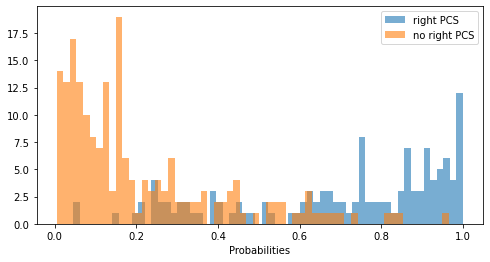

In [20]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='right PCS')
plt.hist(model.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='no right PCS')
#plt.hist(modelMLP.predict_proba(X)[y==1,1], bins=60, alpha=0.6, label='MLP right PCS')
#plt.hist(modelMLP.predict_proba(X)[y==0,1], bins=60, alpha=0.6, label='MLP no right PCS')
plt.xlabel('Probabilities')
#plt.title('Histogram of the probabilites of the right PCS presence [ACC]')
plt.legend()
plt.savefig(f'{path_to_save}/histo_prob_right_PCS_ACC.eps', format='eps')
plt.show()

In [21]:
float((model.predict(X) == (model.predict_proba(X)>0.5)[:,1]).sum())/len(X)

0.95

#### Classification of the HCP embeddings

In [22]:
val_pred = model.predict(X=scl_bdd_hcp)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


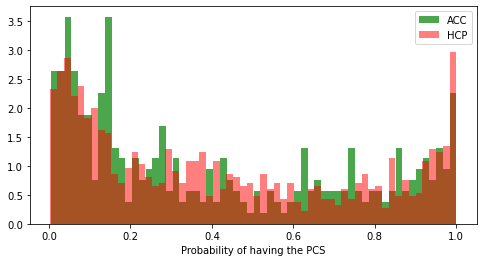

In [23]:
plt.figure(figsize=(8,4))
plt.hist(model.predict_proba(X)[:,1], bins=60, color='g', alpha=0.7, label='ACC', density=True)
plt.hist(model.predict_proba(scl_bdd_hcp)[:,1], bins=60, color='red', alpha=0.5, label='HCP', density=True)
plt.xlabel('Probability of having the PCS')
#plt.title('Histogram of the probabilites of presence of right PCS [ACCP & HCP]')
plt.legend()
plt.savefig(f'{path_to_save}/histo_prob_right_PCS_ACC_HCP.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


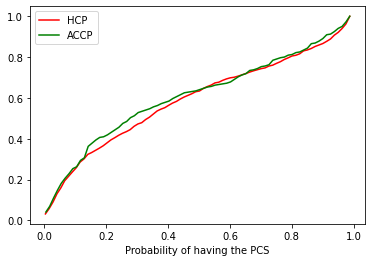

In [26]:
values_ACCP, base_ACCP = np.histogram(model.predict_proba(X)[:,1], bins=80)
cumulative_ACCP = np.cumsum(values_ACCP)
values_HCP, base_HCP = np.histogram(model.predict_proba(scl_bdd_hcp)[:,1], bins=80)
cumulative_HCP = np.cumsum(values_HCP)
# plot the cumulative function
plt.plot(base_HCP[:-1], cumulative_HCP/len(scl_bdd_hcp), c='red', label='HCP')
#plot the survival function
#plt.plot(base_HCP[:-1], len(model.predict_proba(scl_bdd_hcp)[:,1])-cumulative_HCP, c='green', label = 'survival function')

# plot the cumulative function
plt.plot(base_ACCP[:-1], cumulative_ACCP/len(X), c='g', label='ACCP')
#plot the survival function
#plt.plot(base_ACCP[:-1], len(model.predict_proba(X)[:,1])-cumulative_ACCP, c='red', label = 'survival function')
plt.xlabel('Probability of having the PCS')
#plt.title('Cumulative function over the probabilities of presence of the right PCS on the ACC dataset')
plt.legend()
plt.savefig(f'{path_to_save}/cumulative_function_ACC_HCP_right_PCS.eps', format='eps')
plt.show()

In [27]:
UKB_pred = pd.DataFrame({"IID" : list(embeddings_UKB.index),
              "Right_Prob_Pred" : model.predict_proba(scl_bdd_ukb)[:,1]})

UKB_pred

,IID,Right_Prob_Pred
0,sub-1000021,0.992794
1,sub-1000458,0.352072
2,sub-1000575,0.445560
3,sub-1000606,0.983322
4,sub-1000963,0.977704
...,...,...
21047,sub-6023469,0.353273
21048,sub-6023808,0.992351
21049,sub-6023847,0.866407
21050,sub-6024038,0.045662


In [28]:
UKB_pred["IID"] = UKB_pred["IID"].apply(lambda x: x[4:])
UKB_pred

,IID,Right_Prob_Pred
0,1000021,0.992794
1,1000458,0.352072
2,1000575,0.445560
3,1000606,0.983322
4,1000963,0.977704
...,...,...
21047,6023469,0.353273
21048,6023808,0.992351
21049,6023847,0.866407
21050,6024038,0.045662


In [45]:
UKB_pred.to_csv('/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Heritability/data/UKB_right_prob_pred.csv', index=False)

#### SVM classification between ACCP and HCP datasets

In [29]:
scd_bdd_hcp = pd.DataFrame(scl_bdd_hcp, columns=embeddings_HCP.columns)
scd_bdd_hcp['Dataset'] = 0

scd_bdd_ACCP = pd.DataFrame(X,columns=embeddings_HCP.columns)
scd_bdd_ACCP['Dataset'] = 1

In [30]:
scd_bdd_HCP_ACCP = pd.concat([scd_bdd_hcp,scd_bdd_ACCP], axis=0)
scd_bdd_HCP_ACCP

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,dim11,dim12,...,dim246,dim247,dim248,dim249,dim250,dim251,dim252,dim253,dim254,dim255,dim256,Dataset
0,-1.002181,-1.775778,0.495226,1.206868,-1.430915,0.218825,1.166266,-0.518909,0.117877,1.542906,0.789823,-0.746438,...,-0.150068,-0.205403,-1.626476,0.728364,0.572838,0.177519,0.460104,-0.522060,-0.731190,-2.398622,-0.953403,0
1,0.251255,-1.206043,-0.304359,1.682905,-0.377809,0.518208,0.764813,0.064780,-1.116594,0.299383,0.398045,-1.506177,...,0.373756,0.145036,-0.220906,1.039265,0.113246,0.181700,1.463211,-0.044803,0.461337,-1.489536,-0.634557,0
2,1.667009,1.377224,-0.756225,-0.892914,0.043057,-0.651653,-0.616691,-0.664817,-1.090703,0.281928,0.337283,-0.491345,...,1.345942,1.383038,-0.246182,-0.961704,-0.257166,-0.125357,0.208501,-0.988434,-1.392207,-0.030758,-1.674280,0
3,0.379223,-0.997974,2.537503,-0.234181,-1.266975,-1.250863,0.027662,0.921698,-0.101578,0.252630,0.384476,0.797715,...,-0.945454,-1.041907,-1.219650,0.635309,1.600238,-0.121377,-0.710047,-2.311818,-0.683274,-1.940180,-1.224489,0
4,0.307988,-0.947420,0.080539,0.756822,-0.157155,1.806994,-0.622790,0.010341,0.809813,-0.354101,-0.128155,-0.444386,...,-0.118652,-1.217237,1.427439,0.484550,1.111360,0.259810,-0.719202,-1.006766,0.668540,-0.875458,0.203465,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-0.710564,-0.653403,0.734336,-0.290884,0.512626,0.308635,-1.593318,-1.535481,-1.431938,1.405451,-0.100922,-0.614089,...,1.282896,-2.915199,0.056995,-1.438349,-0.840363,-0.175025,-0.368131,-0.735414,0.943711,-1.995386,0.573799,1
316,0.822087,-0.717880,0.817655,0.696726,0.455209,-0.751948,-0.283771,-0.486796,2.351905,0.024228,0.626824,-0.390151,...,1.020509,0.056823,-0.941019,0.122249,1.763389,1.176102,-0.099504,-1.039402,0.506397,-0.768697,-1.091368,1
317,0.546625,0.088426,1.393466,-0.630270,1.063625,0.118638,-1.474443,-2.150164,0.238423,-0.531367,-0.267891,1.606122,...,0.332205,-0.636413,0.031387,0.671193,0.849543,0.042573,0.211568,-0.838222,1.690879,-0.874085,-0.302009,1
318,-0.626863,0.768084,0.586373,1.504744,1.257242,-0.457914,0.949418,0.090788,0.689139,1.334967,0.748513,1.458936,...,0.330575,0.478384,-0.764511,0.006737,1.043060,0.018753,1.111555,0.299150,-0.453666,-0.040880,0.122516,1


In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(scd_bdd_HCP_ACCP.drop("Dataset", axis=1), scd_bdd_HCP_ACCP["Dataset"], test_size=0.01, random_state=40)

In [33]:
model2 = SVC(kernel='linear', probability=True,
            random_state=42,
            C=0.01, class_weight='balanced', decision_function_shape='ovr')

In [34]:
model2.fit(X_train,y_train)
val_predict = cross_val_predict(model2, X_train, y_train, cv=10)
auc = roc_auc_score(y_train, val_predict)
auc

0.7103469249572513

In [35]:
roc_auc_score(y_test, model2.predict_proba(X_test)[:,1])

0.8181818181818182

### Visualization (UMAP)

In [ ]:
import umap

In [40]:
scl_bdd_ukb = scaler.transform(embeddings_UKB)
scd_bdd_UKB = pd.DataFrame(scl_bdd_ukb, columns=embeddings_HCP.columns)
scd_bdd_UKB['Dataset'] = 2

In [41]:
reducer = umap.UMAP()#random_state=5)
scd_bdd_ACCP['Right_PCS'] = y.values
scd_bdd_ACCP['Dataset'] = 'ACC'
scd_bdd_ACCP['Prediction'] = model.predict(X)
scd_bdd_hcp['Right_PCS'] = -1
scd_bdd_hcp['Dataset'] = 'HCP'
scd_bdd_hcp['Prediction'] = model.predict(scl_bdd_hcp)
scd_bdd_UKB['Right_PCS'] = -1
scd_bdd_UKB['Dataset'] = 'UKB'
scd_bdd_UKB['Prediction'] = model.predict(scl_bdd_ukb)

We fit the reducer only on the ACCP database, we concatenate then the two bases and we reduce the m together.

In [42]:
reducer.fit(scd_bdd_UKB.drop(['Right_PCS','Dataset','Prediction'], axis=1))
HCP_and_ACCP = pd.concat([scd_bdd_hcp, scd_bdd_ACCP], axis=0)
HCP_ACCP_UKB = pd.concat([HCP_and_ACCP, scd_bdd_UKB], axis=0)
embedding2D_HCP_ACCP_UKB = reducer.transform(HCP_ACCP_UKB.drop(['Right_PCS','Dataset','Prediction'], axis=1))
embedding2D_HCP_and_ACCP = reducer.transform(HCP_and_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))

In [46]:
def plot_UMAP(ebb2D_dataset, initial_dataset, title, hue):

    unique_values = initial_dataset[hue].unique()

    if type(initial_dataset[hue].iloc[0])==type("str"):
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[0] if x == 'HCP'\
                          else sns.color_palette()[1] if x == 'ACC' \
                          else sns.color_palette()[2] for x in initial_dataset['Dataset']]
        s = [8 if x == 'HCP'\
            else 8 if x == 'ACC' \
            else 0.3 for x in initial_dataset['Dataset']]
    elif -1 in unique_values :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x+1] for x in initial_dataset[hue]]
        s = 20
    else :
        unique_colors = [sns.color_palette()[i] for i in range(len(unique_values))]
        dataset_colors = [sns.color_palette()[x] for x in initial_dataset[hue]]
        s = 20

    plt.figure(figsize=(12,8))
    plt.scatter(
        ebb2D_dataset[:, 0],
        ebb2D_dataset[:, 1],
        s=s,
        c=dataset_colors)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=12)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=unique_colors[i], markersize=10, 
                                label=f'{unique_values[i]}') 
                    for i in range(len(unique_values))]
    plt.legend(handles=legend_handles, title=hue, loc='best')
    plt.savefig(f'{path_to_save}/{title}.eps', format='eps')
    plt.show()

The first figure is made to observe the site effect between ACCP and HCP databases.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


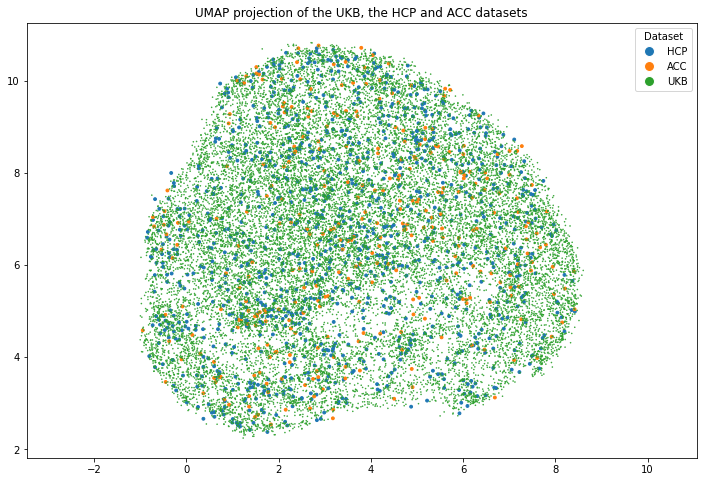

In [47]:
plot_UMAP(embedding2D_HCP_ACCP_UKB, HCP_ACCP_UKB, 'UMAP projection of the UKB, the HCP and ACC datasets', 'Dataset')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


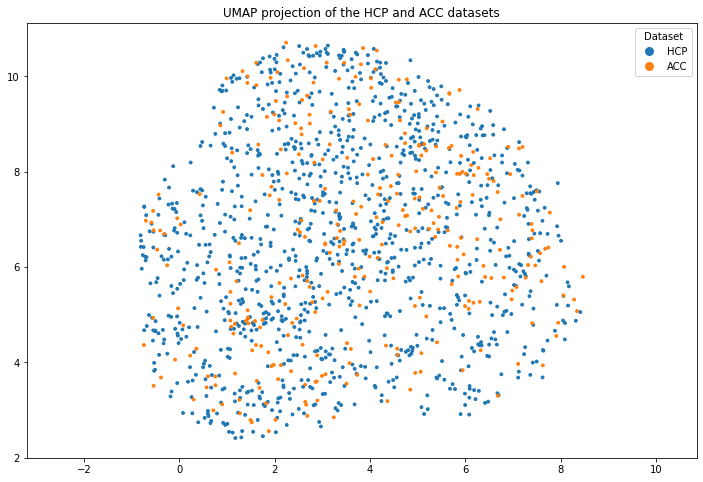

In [48]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACC datasets', 'Dataset')

The second figure is made to point out the position of the people having the paracingular (1) (from the ACCP database), those who don't have it (0) (from the ACCP database), and those we don't know (-1) (from the HCP database).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


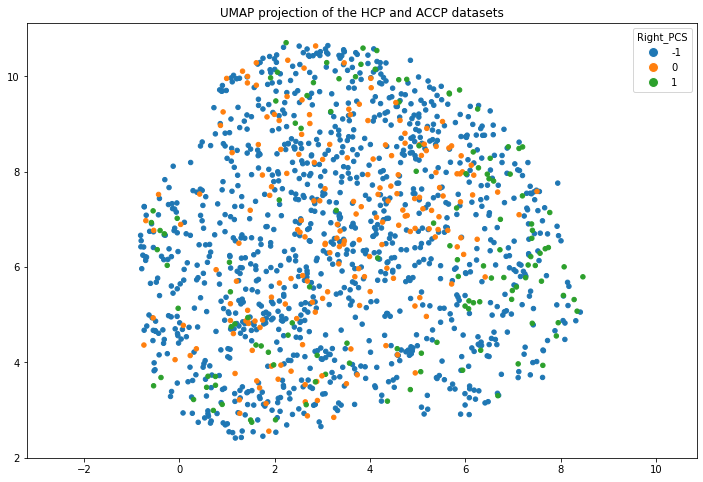

In [49]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACCP datasets', 'Right_PCS')

Then, the following figure highlights the two classes in the ACCP database.

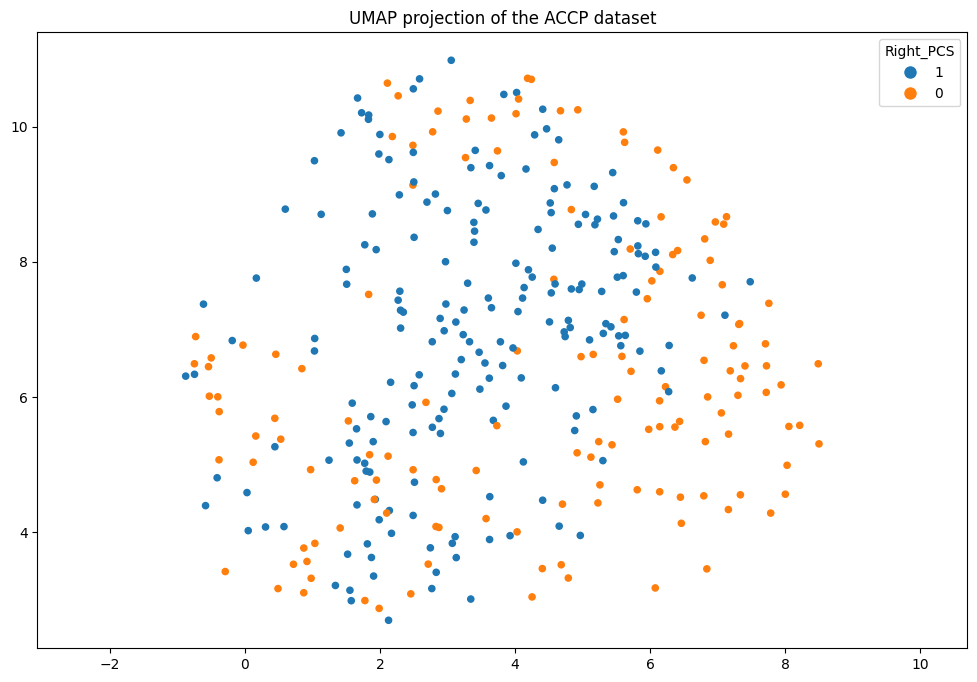

In [81]:
embedding2D_ACCP = reducer.transform(scd_bdd_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))

plot_UMAP(embedding2D_ACCP, scd_bdd_ACCP, 'UMAP projection of the ACC dataset', 'Right_PCS')

We can do the same one by only keeping the 10 best ranked values given the SVM linear classification, on the ACCP database at first, and on the HCP then.

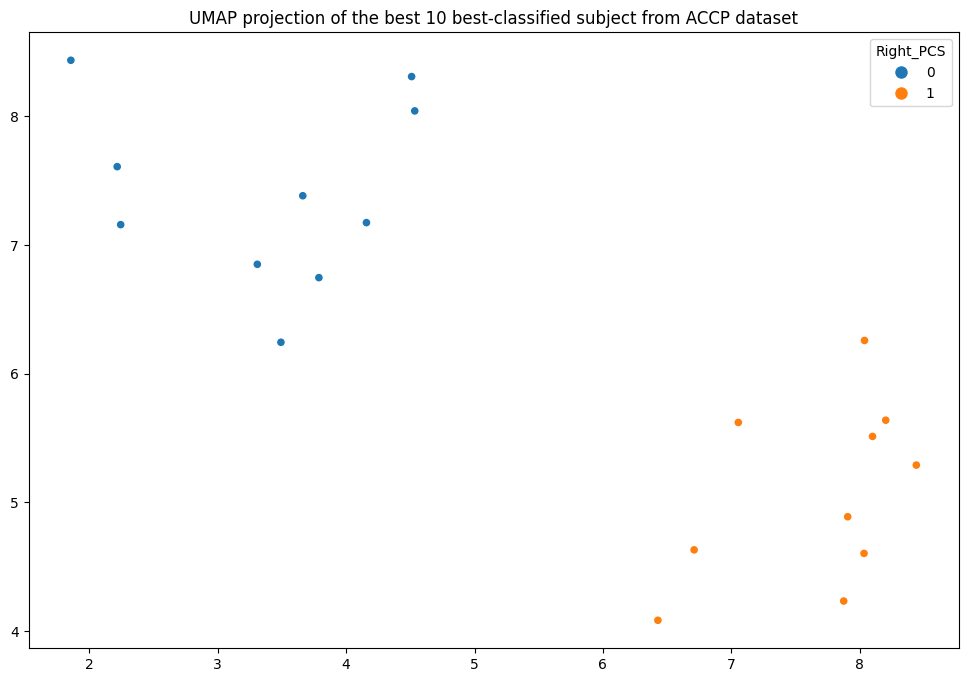

In [82]:
ACCP_proba_pred = model.predict_proba(X)
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[0:10]] # top 10 best ranked label 1
#ACCP_proba_pred[ACCP_proba_pred[:,0].argsort()[-10:]] # top 10 best ranked label 0
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]] # check if the prediction are also the ground truth (that's a yes)
#scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]] # check if the prediction are also the ground truth (that's a yes as well)
best_ACCP = pd.concat([scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[-10:]],scd_bdd_ACCP.iloc[ACCP_proba_pred[:,0].argsort()[0:10]]], axis=0)
embedding2D_best_classified_ACCP = reducer.transform(best_ACCP.drop(['Right_PCS','Dataset','Prediction'], axis=1))
plot_UMAP(embedding2D_best_classified_ACCP, best_ACCP, 'UMAP projection of the best 10 best-classified subject from ACC dataset', 'Right_PCS')


In [96]:
ACCP_right_Prd_df = pd.DataFrame({'long_name' : list(ebdd_lbl_ACCP.index), 'Right_Pred' :  ACCP_proba_pred[:,1]})
ACCP_right_Prd_df

,long_name,Right_Pred
0,1-03HUBJO_t0,0.915775
1,1-08ANDTI_t0,0.812264
2,1-11LEBJO_t0,0.928644
3,1-15LEHMI_t0,0.174454
4,1-17COLMA_t0,0.127040
...,...,...
336,sub-inhibition25_ses-pretraining_T1w,0.960166
337,sub-inhibition26_ses-pretraining_T1w,0.390434
338,sub-inhibition28_ses-pretraining_T1w,0.338666
339,sub-inhibition29_ses-pretraining_T1w,0.091000


In [99]:
ACCP_right_Prd_df.to_csv('/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Heritability/data/ACCP_right_Prd.csv', index=False)

Let's see the SVC borders on the UMAP

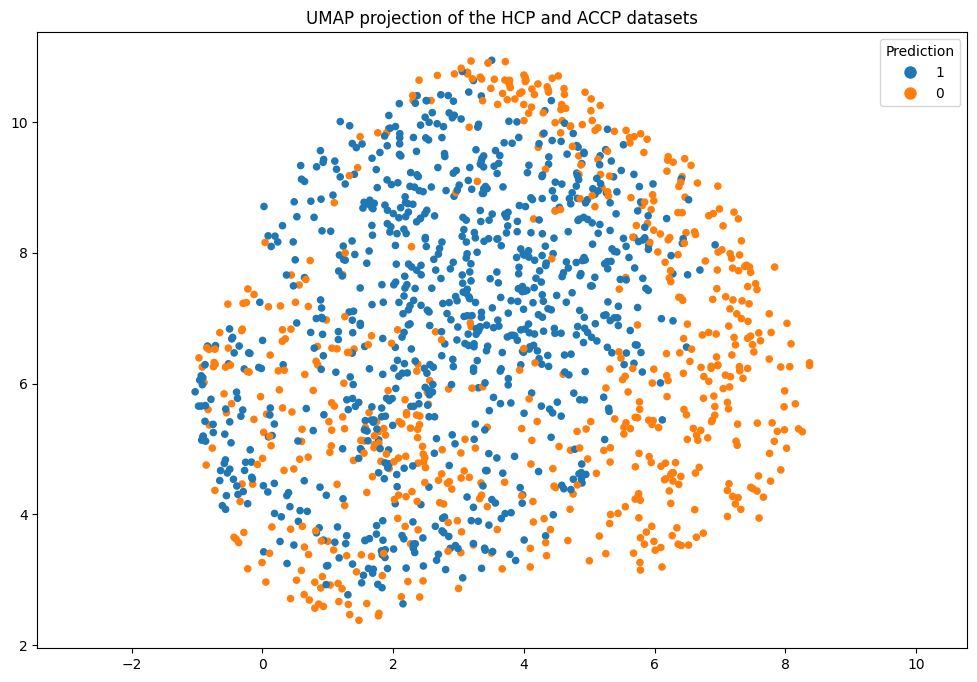

In [37]:
plot_UMAP(embedding2D_HCP_and_ACCP, HCP_and_ACCP, 'UMAP projection of the HCP and ACC datasets', 'Prediction')

We can get the ID of the best classified subject and see in the Anatomist if the paracingular is there or not.

In [36]:
HCP_proba_pred = model.predict_proba(scd_bdd_hcp.drop(['Right_PCS', 'Dataset', 'Prediction'], axis=1))
HCP_proba_pred[HCP_proba_pred[:,0].argsort()[0:5]]

/neurospin/dico/adufournet/Runs/01_Heritability_Right_PCS_HCP/Program/2023_jlaval_STSbabies/venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


array([[1.20736733e-05, 9.99987926e-01],
       [1.22149605e-05, 9.99987785e-01],
       [2.94408824e-03, 9.97055912e-01],
       [3.87704490e-03, 9.96122955e-01],
       [4.06366816e-03, 9.95936332e-01]])

In [37]:
HCP_proba_pred[HCP_proba_pred[:,0].argsort()[-5:]]

array([[0.98003314, 0.01996686],
       [0.98027199, 0.01972801],
       [0.98243224, 0.01756776],
       [0.98493723, 0.01506277],
       [0.98535751, 0.01464249]])

In [38]:
embeddings_HCP.iloc[HCP_proba_pred[:,0].argsort()[1114//2-2:1114//2+2]].index

Index([622236, 134324, 922854, 929464], dtype='int64', name='ID')

First 5 people predicted without paracingulate sulcus.

In [39]:
embeddings_HCP.iloc[HCP_proba_pred[:,0].argsort()[-5:]].index

Index([725751, 732243, 171128, 131621, 138231], dtype='int64', name='ID')

First 5 people predicted with paracingulate sulcus.

In [40]:
embeddings_HCP.iloc[HCP_proba_pred[:,0].argsort()[0:5]].index

Index([693764, 959574, 219231, 101309, 151728], dtype='int64', name='ID')

### CSV file generation for SOLAR

In [41]:
df_HCP_binary_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict(X=scl_bdd_hcp)})

df_HCP_binary_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data//HCP_binary_pred_PCS.csv', index=False)
df_HCP_binary_pred_PCS.sort_values('IID')

OSError: Cannot save file into a non-existent directory: '/volatile/ad279118/Runs/0_heredity_PCS/data'

In [ ]:
df_HCP_prob_pred_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,1]})

df_HCP_prob_pred_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data//HCP_prob_pred_PCS.csv', index=False)
df_HCP_prob_pred_PCS

,IID,Pred
0,100206,0.486223
1,100307,0.930033
2,100408,0.166425
3,100610,0.191372
4,101006,0.179137
...,...,...
1109,992774,0.771308
1110,993675,0.056650
1111,994273,0.118772
1112,995174,0.875460


In [ ]:
df_HCP_prob_pred_without_PCS = pd.DataFrame({"IID" : list(embeddings_HCP.index),
              "Pred" : model.predict_proba(scl_bdd_hcp)[:,0]})

df_HCP_prob_pred_without_PCS.to_csv('/neurospin/dico/adufournet/Runs/02_Heritability_Left_PCS_HCP/Heritability/data//HCP_prob_pred_without_PCS.csv', index=False)
df_HCP_prob_pred_without_PCS

,IID,Pred
0,100206,0.513777
1,100307,0.069967
2,100408,0.833575
3,100610,0.808628
4,101006,0.820863
...,...,...
1109,992774,0.228692
1110,993675,0.943350
1111,994273,0.881228
1112,995174,0.124540
